# Pattern Compare

Aims to answer the question **Are there any key similarities or differences between malicious and benign samples in terms of API Call Patterns?** in **4.2.6. Dataset Analysis** of the study.

Note that this notebook only makes use of the verified xxxx_SampleHash_Common.csv file which represents a significant majority of the entire Oliveira dataset.  

## Import Libraries/Datasets

In [13]:
import pandas as pd
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
import time

malicious_df = pd.read_csv('./Clustering/(EDITED)KMeans_SampleHash_Common.csv', low_memory=False) #This should point to a verified <DataClustering>_SampleHash_Common.csv file
benign_df = pd.read_csv('./Clustering/Benign/API_Patterns.csv') #This should point to the API_Patterns.csv file

#Load list of API calls
API_LIST = "api_calls.txt"
DELIMITER = "NaN"
API_FILE = open(API_LIST,"r")
APIS = API_FILE.readline().split
# APIS.append(DELIMITER) #serves as a label for NaN values for Instance-based datasets
API_FILE.close()

## DataFrame Preview

In [2]:
malicious_df.replace(to_replace='-',value='_', inplace=True)
malicious_df

,cluster,hash,Type 1,Type 2,Type 3,pattern
0,0,490d584c7d303ed35c673460b63f3ca8,trojan,dropper,pua,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
1,0,9ab8ea1d2d68a0d4110df413e677976c,trojan,hacktool,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
2,0,adbc74815ef2bd1ea4967abad812233d,trojan,_,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
3,0,f6eb4841bba3a4cee747700dc0ee1609,_,_,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
4,0,f5a0ad49337ebc87897698e70d03364e,trojan,dropper,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
...,...,...,...,...,...,...
1756,198,d24b78bd73f17379ed62e4c776b4f66e,trojan,adware,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
1757,198,f666dd4b3a53b7fe71f8976fa09bfdfb,trojan,adware,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
1758,199,b6d6520b608875282d831b1e983cd5e5,_,_,_,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."
1759,199,18bce1a594550daf8b3f318de48c1674,trojan,dropper,_,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."


In [3]:
#Drop row that is falsely labelled.
malicious_df.drop(malicious_df[(malicious_df['Type 1']=='_')&(malicious_df['Type 2']=='_')&(malicious_df['Type 3']=='_')].index, inplace=True)
malicious_df

,cluster,hash,Type 1,Type 2,Type 3,pattern
0,0,490d584c7d303ed35c673460b63f3ca8,trojan,dropper,pua,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
1,0,9ab8ea1d2d68a0d4110df413e677976c,trojan,hacktool,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
2,0,adbc74815ef2bd1ea4967abad812233d,trojan,_,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
4,0,f5a0ad49337ebc87897698e70d03364e,trojan,dropper,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
5,0,4c972b447659f1e86769eb43593fd2a5,trojan,downloader,dropper,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
...,...,...,...,...,...,...
1755,198,0226e311ed2648ff399c7902fc113421,adware,trojan,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
1756,198,d24b78bd73f17379ed62e4c776b4f66e,trojan,adware,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
1757,198,f666dd4b3a53b7fe71f8976fa09bfdfb,trojan,adware,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
1759,199,18bce1a594550daf8b3f318de48c1674,trojan,dropper,_,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."


In [4]:
benign_df

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,pattern
0,5b51d65972a349f90a86984c26b12b30,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,NtQueryDirectoryFile,NtClose,LdrGetProcedureAddress,CoCreateInstance,NtOpenSection,CreateDirectoryW,NtCreateFile,LdrGetProcedureAddress,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."
1,ceb8cc125478fad641daa4e04e9b2f19,GetSystemInfo,NtAllocateVirtualMemory,NtOpenSection,GetTempPathW,CreateDirectoryW,GetFileAttributesW,FindFirstFileExW,DeleteFileW,NtQueryDirectoryFile,...,NtClose,NtCreateMutant,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,NtClose,NtCreateMutant,NtClose,NtCreateFile,"GetSystemInfo,NtAllocateVirtualMemory,NtOpenSe..."
2,f108600edf46d7c20f6acc522aeba6df,GetSystemTimeAsFileTime,NtProtectVirtualMemory,SetUnhandledExceptionFilter,GetTimeZoneInformation,GetSystemTimeAsFileTime,GetTimeZoneInformation,GetSystemTimeAsFileTime,GetTimeZoneInformation,GetSystemTimeAsFileTime,...,SetErrorMode,GetFileAttributesExW,SetErrorMode,NtAllocateVirtualMemory,SetErrorMode,GetFileAttributesExW,SetErrorMode,FindFirstFileExW,NtQueryDirectoryFile,"GetSystemTimeAsFileTime,NtProtectVirtualMemory..."
3,711be6337cb78a948f04759a0bd210ce,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,LdrGetProcedureAddress,NtAllocateVirtualMemory,LdrGetProcedureAddress,GetSystemMetrics,LdrLoadDll,LdrGetProcedureAddress,GetSystemMetrics,NtAllocateVirtualMemory,LdrLoadDll,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
4,6de26f67ceb1e3303b889489010f4c3f,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,NtQueryDirectoryFile,NtClose,LdrGetProcedureAddress,GetSystemWindowsDirectoryW,LoadStringW,GetSystemWindowsDirectoryW,GetSystemDirectoryW,RegOpenKeyExW,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,d282ef96a93986f89825508812958354,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,LdrGetProcedureAddress,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."
1075,c0389d256f976044adf570f0df908953,GetSystemTimeAsFileTime,SetUnhandledExceptionFilter,GetCursorPos,SetErrorMode,FindResourceW,SetWindowsHookExW,CoInitializeEx,NtDuplicateObject,NtAllocateVirtualMemory,...,NtAllocateVirtualMemory,LdrLoadDll,LdrGetProcedureAddress,NtAllocateVirtualMemory,GetSystemMetrics,RegOpenKeyExW,NtAllocateVirtualMemory,GetSystemMetrics,NtAllocateVirtualMemory,"GetSystemTimeAsFileTime,SetUnhandledExceptionF..."
1076,20316e717de5db169aecbb67377504ce,SetUnhandledExceptionFilter,NtCreateMutant,NtAllocateVirtualMemory,NtClose,NtCreateMutant,NtClose,NtCreateMutant,NtClose,NtAllocateVirtualMemory,...,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,"SetUnhandledExceptionFilter,NtCreateMutant,NtA..."
1077,ce945d424b93ea73fbbedf0254f6bc07,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,FindResourceExW,LoadResource,"NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOp..."


## Identify Malware Types

In [5]:
'''Identify popular malware types in the dataset per Type as validated by VirusTotal.'''

def identify(malware_type:str):
    '''Identify and count the malware types per type'''
    print(f"{malware_type.upper()} LABEL")
    unique = list(malicious_df[malware_type].unique())
    if '_' in unique:
        unique.remove('_')
    quantities = []
    for t in unique:
        quantities.append([t, len(malicious_df[malicious_df[malware_type]==t])])
    quantities.sort(key=lambda ls: ls[1], reverse=True)
    for q in quantities:
        print(q)
    print("")

'''Executes the identification for each type'''
types = ['Type 1', 'Type 2', 'Type 3']
for i in types:    
    identify(i)

TYPE 1 LABEL
['trojan', 1340]
['adware', 195]
['downloader', 78]
['ransomware', 19]
['miner', 14]
['dropper', 4]
['pua', 3]
['nsismod', 3]
['virus', 1]
['hacktool', 1]
['avaquest', 1]
['opencandy', 1]
['syncopate', 1]
['techjoydown', 1]
['msil', 1]
['fugrafa', 1]

TYPE 2 LABEL
['adware', 846]
['trojan', 228]
['downloader', 77]
['dropper', 71]
['pua', 31]
['miner', 26]
['spyware', 21]
['ransomware', 17]
['virus', 13]
['banker', 12]
['worm', 7]
['hacktool', 1]
['candyopen', 1]
['nsismod', 1]

TYPE 3 LABEL
['pua', 171]
['virus', 135]
['downloader', 115]
['trojan', 61]
['adware', 55]
['dropper', 45]
['spyware', 7]
['ransomware', 4]
['hacktool', 3]
['banker', 2]
['worm', 1]



## Extract API Patterns

In [6]:
malicious_patterns = malicious_df['pattern'].to_list()
print(len(malicious_patterns))
malicious_patterns

1664


['GetSystemTimeAsFileTime,NtCreateMutant,GetSystemTimeAsFileTime,NtOpenKeyEx,NtQueryKey,NtOpenKeyEx,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExW,LdrGetProcedureAddress,RegQueryInfoKeyW,LdrGetProcedureAddress,RegEnumKeyExW,RegOpenKeyExW,RegQueryInfoKeyW,LdrGetProcedureAddress,RegEnumValueW,LdrGetProcedureAddress,RegCloseKey,GetFileAttributesW,RegOpenKeyExW,LdrGetProcedureAddress,RegQueryValueExW,RegCloseKey,NtOpenFile,NtQueryDirectoryFile,NtClose,RegOpenKeyExW,RegQueryInfoKeyW,RegCloseKey,RegOpenKeyExW,RegQueryInfoKeyW,RegEnumValueW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,NtOpenFile,RegOpenKeyExW,RegQueryInfoKeyW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,NtOpenFile,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,GetSystemTimeAsFileTime,NtQuerySystemInformation,NtProtectVirtualMemory,GetSystemDirectoryW,LdrGetDllHandle,LdrLoadDll,GetSystemDirectoryW,LdrGetDllHandle,NtOpenKey,Nt

In [7]:
benign_patterns = benign_df['pattern'].to_list()
print(len(benign_patterns))
benign_patterns

1079


['SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,NtOpenSection,NtMapViewOfSection,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrLoadDll,LdrGetProcedureAddress,GetSystemWindowsDirectoryW,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,RegOpenKeyExA,LdrGetProcedureAddress,CreateActCtxW,LdrLoadDll,LdrGetProcedureAddress,GetSystemDirectoryW,RegOpenKeyExA,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,LdrGetProcedureAddress,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,LdrGetProcedureAddress,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,LdrGetProcedureAddress,GetVolumeNameForVolumeMountPointW

## Compare API Call Patterns

**Note that this uses the full API Call Patterns (i.e., Time-based Behaviors)**

Find those most similar unique malicious API call patterns that match those unique benign API call patterns.

In [8]:
#This code block may take a while to complete. SequenceMatcher.ratio() is deemed slow even by its documentation.
print("Comparing API Call Patterns...")
ratio = 0
ratios = []
start = time.time()

unique_malicious = list(malicious_df['pattern'].unique())
unique_benign = list(benign_df['pattern'].unique())
print(f"No. of unique malicious patterns: {len(unique_malicious)}")
print(f"No. of unique benign patterns: {len(unique_benign)}")
print("")
for m,ma in enumerate(unique_malicious): #For efficiency's sake, let's just compare it to unique malicious samples. Hashes that match the same malicious pattern will be collected in batches instead of one by one.
    mal_df = malicious_df[malicious_df['pattern']== ma]
    st = time.time()
    for b,be in enumerate(unique_benign): #For efficiency's sake, let's just compare it to unique benign samples. Hashes that match the same benign pattern will be collected in batches instead of one by one.
        ratios.append({'ratio': SequenceMatcher(None, ma, be).ratio(), #<=== SequenceMatcher is slow BTW.
                       'benign_pattern':be, 'malicious_pattern': ma,
                       'Type 1':mal_df['Type 1'].to_list(), 
                       'Type 2':mal_df['Type 2'].to_list(), 
                       'Type 3':mal_df['Type 3'].to_list(), 
                       'malicious_hash':mal_df['hash'].to_list(), 
                       'benign_hash':benign_df[benign_df['pattern'] == be]['hash'].to_list()})
    print(f"Unique Mal. Pattern {m} {ma[0:30]}... @ {time.time()-st:.4f}s")
elapsed = time.time()-start

Comparing API Call Patterns...
No. of unique malicious patterns: 199
No. of unique benign patterns: 624

Unique Mal. Pattern 0 GetSystemTimeAsFileTime,NtCrea... @ 5.8902s
Unique Mal. Pattern 1 LdrGetDllHandle,LdrGetProcedur... @ 7.2593s
Unique Mal. Pattern 2 GetSystemTimeAsFileTime,LdrLoa... @ 5.1652s
Unique Mal. Pattern 3 SetErrorMode,OleInitialize,Ldr... @ 4.5909s
Unique Mal. Pattern 4 GetSystemTimeAsFileTime,GetSys... @ 4.9197s
Unique Mal. Pattern 5 RegOpenKeyExA,NtOpenKey,NtQuer... @ 4.2676s
Unique Mal. Pattern 6 GetSystemTimeAsFileTime,NtAllo... @ 4.9299s
Unique Mal. Pattern 7 LdrLoadDll,LdrGetProcedureAddr... @ 4.2211s
Unique Mal. Pattern 8 GetSystemTimeAsFileTime,LdrLoa... @ 5.1331s
Unique Mal. Pattern 9 LdrLoadDll,LdrGetProcedureAddr... @ 4.0350s
Unique Mal. Pattern 10 NtClose,NtOpenKey,NtQueryValue... @ 4.4250s
Unique Mal. Pattern 11 GetSystemTimeAsFileTime,LdrLoa... @ 5.3675s
Unique Mal. Pattern 12 NtClose,NtOpenKey,NtQueryValue... @ 4.4982s
Unique Mal. Pattern 13 NtAllocateV

In [9]:
size = len(benign_patterns) * len(malicious_patterns)
for r in ratios:
    ratio += r['ratio']
ratio /= size
ratios.sort(reverse=True,key=lambda ratio: ratio['ratio'])
print(f"Average Similarity Ratio: {ratio*100:.4f}%")
print(f"Time Elapsed: {elapsed:0.4f}s")
print(f"Time per Sample: {elapsed/size:0.4f}s")
print("")

Average Similarity Ratio: 0.8129%
Time Elapsed: 1028.0927s
Time per Sample: 0.0006s



### Distribution of Similarity Ratios

The graph that the code block below produces indicates the most common similarity ratio between malicious and benign samples in terms of unique API calls.

Being bias on the left means that most malicious API Call Patterns are different to that found in benign API Call Patterns (but that does not mean that there are no same ones that exist).

Being bias on the right means that most malicious API Call Patterns are the same to that found in benign API Call Patterns (but that does not mean that there are no different ones that exist).

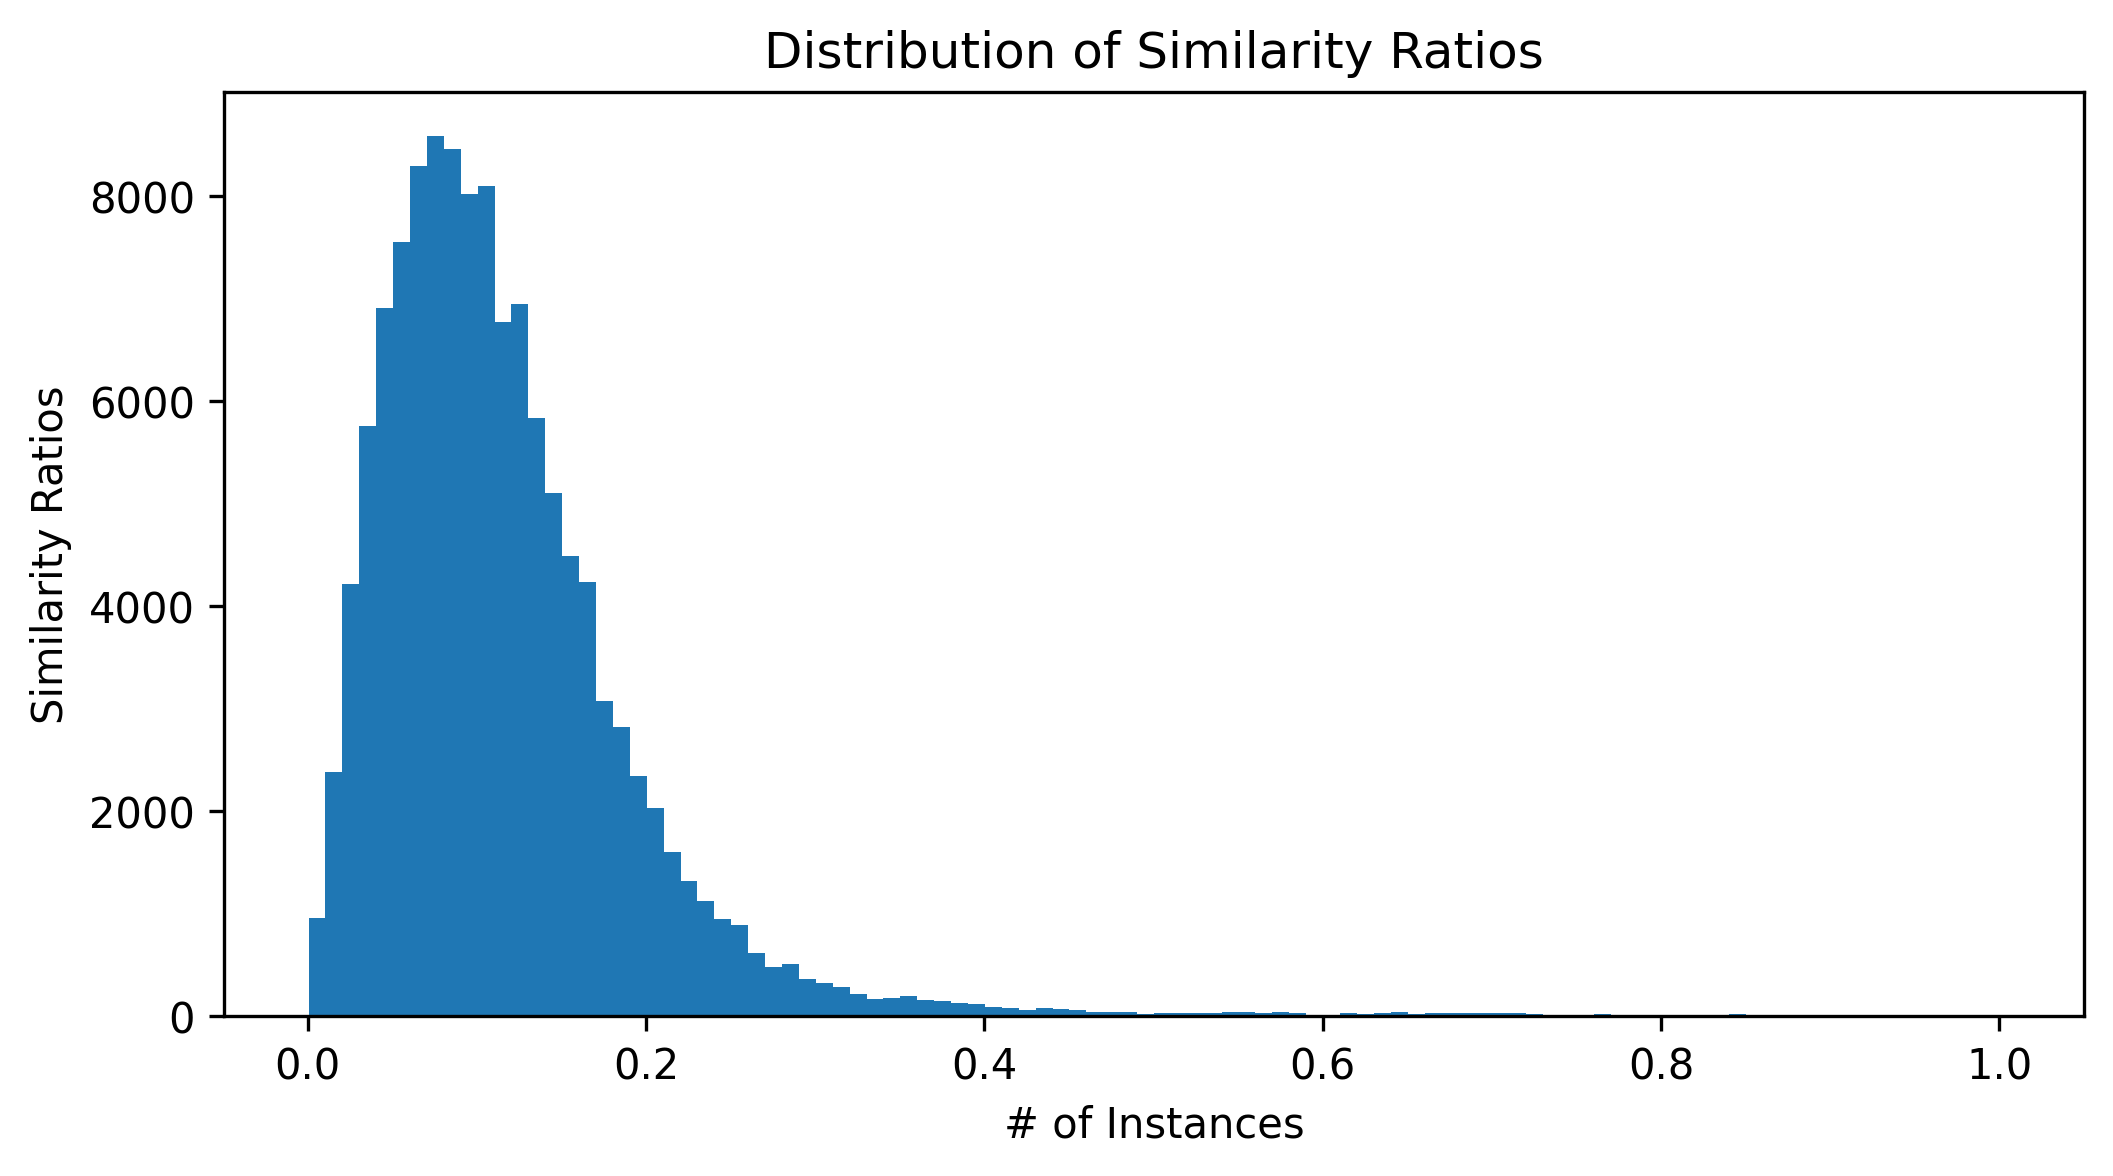

In [82]:
ratio_only = []
for r in ratios:
    ratio_only.append(r['ratio'])
plt.figure(figsize=(8,4), dpi=300)
plt.title('Distribution of Similarity Ratios')
plt.ylabel('Similarity Ratios')
plt.xlabel('# of Instances')
n, bins, patches = plt.hist(ratio_only, bins=100, orientation='vertical')
plt.show()

In [93]:
def print_comparison(types:str, ratios:list, max:int):
    if max > len(ratios):
        print(f"The specified `max` value ({max}) exceeds the number available ratios to select.")
        max = len(ratios)
    states = []
    output = ""
    for r in range(0,max):
        output += f"MATCH {r+1}\n"
        output += f"Malicious Hashes ({len(ratios[r]['malicious_hash'])}):\n"
        for t in range(len(ratios[r]['malicious_hash'])):
            output += f"\t{ratios[r]['malicious_hash'][t]} - {ratios[r]['Type 1'][t]} {ratios[r]['Type 2'][t]} {ratios[r]['Type 3'][t]}" + "\n"
        output += f"Benign Hashes ({len(ratios[r]['benign_hash'])}):\n"
        for b in range(len(ratios[r]['benign_hash'])):
            output += f"\t{ratios[r]['benign_hash'][b]}\n"
        output += f"Score: {ratios[r]['ratio']:.4f}\n"
        output += f"Malicious API Call Pattern: {ratios[r]['malicious_pattern']}\n"
        output += f"Benign API Call Pattern: {ratios[r]['benign_pattern']}\n"
        output += "\n"
        for t in range(len(ratios[r]['malicious_hash'])):
            states.append(ratios[r]['Type 1'][t]+' '+ratios[r]['Type 2'][t]+' '+ratios[r]['Type 3'][t])
    print(output)
    print(output, file=open(f"PatternCompare_{types}.txt",'w'))
    return states

## High Matching Ratios

Samples with high matching ratio in terms of pattern (i.e., states) are ideally the following:
1. The malicious sample is a `trojan` hence must have similar behaviors as a benign software. It might be the limitation of the dataset having only the first 100 API calls and may not have included the rest.
2. The malicious sample is falsely labelled (i.e., `_ _ _`)as malicious (i.e., false-positive) which is supported by it matching the behavior of benign samples.

In [94]:
# MOST SIMILAR API CALL PATTERNS TO BOTH MALICIOUS AND BENIGN SAMPLES
top = 10 #Prints Top 50 Most Similar
ratios.sort(reverse=True,key=lambda ratio: ratio['ratio'])
states = print_comparison("similar", ratios, 20) 
common_states = pd.Series(states).sort_values()
display(f"Malware Types of the Top {top} Most Matching API Call Patterns to Benign Samples:", pd.Series(common_states).sort_values().value_counts())

MATCH 1
Malicious Hashes (9):
	490d584c7d303ed35c673460b63f3ca8 - trojan dropper pua
	9ab8ea1d2d68a0d4110df413e677976c - trojan hacktool _
	adbc74815ef2bd1ea4967abad812233d - trojan _ _
	f5a0ad49337ebc87897698e70d03364e - trojan dropper _
	4c972b447659f1e86769eb43593fd2a5 - trojan downloader dropper
	f23ecef8b4f9618644532605576dc981 - trojan dropper _
	a173ee9b4b2d991c37af8180bf511867 - trojan downloader dropper
	233cd454304dc47b37830ce11a045eef - trojan _ _
	fded249c870bd4014890c497ecc4e5b7 - trojan dropper pua
Benign Hashes (2):
	1d5be1a1f06fb4af76db691286667685
	e17c7fc99e55278c9377e0ba686b4002
Score: 1.0000
Malicious API Call Pattern: GetSystemTimeAsFileTime,NtCreateMutant,GetSystemTimeAsFileTime,NtOpenKeyEx,NtQueryKey,NtOpenKeyEx,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExW,LdrGetProcedureAddress,RegQueryInfoKeyW,LdrGetProcedureAddress,RegEnumKeyExW,RegOpenKeyExW,RegQueryInfoKeyW,LdrGetProcedureAddress,RegEnumValueW,LdrGetProcedureAddress,RegCloseKey,GetFileAttributesW,RegOpenK

'Malware Types of the Top 10 Most Matching API Call Patterns to Benign Samples:'

trojan _ _                   43
trojan adware _              38
adware trojan pua            19
trojan dropper _             12
adware trojan downloader     10
adware trojan ransomware      9
trojan adware downloader      8
downloader trojan _           8
adware trojan _               7
trojan dropper pua            4
trojan downloader dropper     4
adware _ _                    3
nsismod _ _                   3
downloader trojan adware      2
trojan downloader adware      2
adware virus _                2
trojan hacktool _             2
adware pua _                  1
opencandy candyopen _         1
fugrafa nsismod _             1
downloader _ _                1
adware trojan virus           1
adware pua trojan             1
trojan dropper virus          1
trojan miner dropper          1
trojan spyware _              1
trojan worm _                 1
Name: count, dtype: int64

## Low Matching Ratios

Samples with low matching ratio in terms of pattern (i.e., states) are ideally the following:
1. The malicious sample is a `trojan` hence must have similar behaviors as a benign software. It might be the limitation of the dataset having only the first 100 API calls and may not have included the rest.
2. The malicious sample is falsely labelled as malicious (i.e., false-positive) which is supported by it matching the behavior of benign samples.

In [95]:
# MOST DIFFERENT API CALL PATTERNS TO BOTH MALICIOUS AND BENIGN SAMPLES
ratios.sort(reverse=False,key=lambda ratio: ratio['ratio'])
states = print_comparison("different",ratios, 20) #Prints Top 20
uncommon_states = pd.Series(states).sort_values()
display(f"Malware Types of the Top {top} Least Matching API Call Patterns to Benign Samples:", pd.Series(uncommon_states).sort_values().value_counts())

MATCH 1
Malicious Hashes (7):
	1901fc38186ae1bed1b5da4874cfa382 - trojan banker _
	ee964197100d076072b6fdc5bfaf297b - trojan banker _
	ead8622597de71be8384b3849c20216f - trojan banker _
	1da9e321b4857c7ffc9e54a6449749c5 - trojan banker _
	b523acc5da1636551efdbdbca0cbd213 - trojan banker pua
	ded641f741d8eda8be254e981d37c29c - trojan banker _
	1feb2a391cd4f44a9400b9b85caa141f - trojan banker _
Benign Hashes (2):
	5af545fe09a6680a1b4e1b3aaa2a8031
	fb4462fd7462e2e5dd100132ed7b38df
Score: 0.0005
Malicious API Call Pattern: NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInformation,NtQueryInformationFile,NtQuerySystemInforma

'Malware Types of the Top 10 Least Matching API Call Patterns to Benign Samples:'

trojan banker _              48
trojan _ _                   27
trojan adware _              13
trojan pua _                  9
trojan banker pua             8
trojan dropper _              6
ransomware trojan _           5
trojan spyware _              5
trojan adware virus           4
adware trojan virus           4
trojan downloader _           3
trojan dropper pua            3
ransomware trojan dropper     2
ransomware trojan pua         2
trojan adware downloader      2
adware trojan downloader      2
msil _ _                      1
adware trojan _               1
trojan adware pua             1
hacktool pua trojan           1
downloader adware trojan      1
trojan pua adware             1
adware _ _                    1
Name: count, dtype: int64